# 0. Import packages
Keep cell, and leave blank. If PyCharm (IDE) automatically imports any functions then they'll appear in this cell. This allows for easy sorting.

In [175]:
# Intentionally blank


## 0.1. Clear the workspace

In [176]:
# Clear all variables in the workspace
%reset -f

## 0.2. Ubermag

In [177]:
import oommfc as oc
oc.runner.runner

TclOOMMFRunner(/Applications/oommf/oommf/oommf.tcl)

In [178]:
import discretisedfield as df
import micromagneticmodel as mm

## 0.3. My custom modules

In [ ]:
from custom_helper_files import (custom_image_processing as cip,
                                 custom_system_properties as csp,
                                 custom_dispersion_relations as cdr,
                                 custom_physics_equations as cpe,
                                 custom_temporal_field_tcl_scripts as ctf,
                                 convert_field_units)

from custom_ubermag_utils import damping_absorbing_region as dar

## 0.4. General Python

In [ ]:
%matplotlib inline
import numpy as np

# 1. Define the overall system

Set your data and figure output directories; used for saving the simulation data and figures, respectively. The `json_params` dictionary is used to store parameters that will be passed to the JSON file.

In [181]:
data_output = '/Users/cameronmceleney/Data/2025-04-17/Ubermag_data'
figs_output = '/Users/cameronmceleney/Data/2025-04-17/Ubermag_output'

OOMMF will automatically generate a JSON file containing most simulation parameters when a driver (`oommfc.Driver`) is executed. However, many parameters used to define customised fields (`df.Field`) will only appear, if at all, in binary-encoded files.

To log these parameters, we can piggyback on OOMMF's auto-generated JSON by passing a dictionary of these parameters to the final driver.

In [182]:
json_params = {}

## 1.1. Container

- `system.name` will be used extensively for naming output files and figures. Ensure it is descriptive and key-search friendly.
- Assume there is no temperature `T` to consider.

In [183]:
system = mm.System(name='dmi_paper_validation',
                   T=0)

I prefer to use my own custom system properties class as this allows me to define dimensions, cell sizes, and other properties in a single place prior to declaring any region (`df.Region`) or mesh (`df.Mesh`) instances. For me, `csp.SystemProperties` improve code readability.

> To only use functionality defined by Ubermag one must first define a mesh and then a region. The dimensions can be extracted from either, while the cell size is a property of the mesh.

In [184]:
# System dimensions
system_prop = csp.SystemProperties(length=8802e-9,
                                   width=1e-9,
                                   thickness=12e-9)

# System mesh cell size
system_prop.cell = (1e-9, 1e-9, 12e-9)
system_prop.units = ('m', 'm', 'm')
system_prop.update_numcells()

## 1.2. Primary region

All models must consistent of a primary `df.Region` from which the `df.Mesh` can be determined. Now, we set up the container for this primary region.

> The command `%%capture` is a Jupyter magic command that suppresses the output of the cell. Comment it out to see the cell's output.

In [185]:
%%capture
system_region = csp.MyRegions(system.name + "_regions")

system_region.main(p1=system_prop.p1,
                   p2=system_prop.p2,
                   dims=('x', 'y', 'z'),
                   units=system_prop.units)

## 1.2.1. Material subregions
One could solely use the `domain` container we just created to also hold these subregions. For demonstration purposes more than anything else, we first create a second, separate container for the subregions.

While each subregion is separated define, we are somewhat able to automate the process by letting one subregion be the base for the next.

In [186]:
system_subregions = csp.MyRegions(system.name + "_subregions")

In [187]:
%%capture
system_subregions.fixedLhs(p1=system_region.main.pmin,
                           p2=(system_prop.cell[0],
                               system_prop.width,
                               system_prop.thickness),
                           dims=('x', 'y', 'z'),
                           units=system_prop.units)

system_subregions.dampingLhs(p1=csp.add_tuples(system_subregions.fixedLhs.pmax,
                                               dims='x',
                                               base=system_prop.p1),
                             p2=csp.add_tuples(system_subregions.fixedLhs.pmax,
                                               system_prop.cell,
                                               mult=600,
                                               dims='x'),
                             dims=('x', 'y', 'z'),
                             units=system_prop.units)

system_subregions.freeLhs(p1=csp.add_tuples(system_subregions.dampingLhs.pmax,
                                            dims='x',
                                            base=system_prop.p1),
                          p2=csp.add_tuples(system_subregions.dampingLhs.pmax,
                                           system_prop.cell,
                                           mult=3250,
                                           dims='x'),
                          dims=('x', 'y', 'z'),
                          units=system_prop.units)

system_subregions.gradientLhs(p1=csp.add_tuples(system_subregions.freeLhs.pmax,
                                                dims='x',
                                                base=system_prop.p1),
                              p2=csp.add_tuples(system_subregions.freeLhs.pmax,
                                                system_prop.cell,
                                                mult=490,
                                                dims='x'),
                              dims=('x', 'y', 'z'),
                              units=system_prop.units)

system_subregions.driven(p1=csp.add_tuples(system_subregions.gradientLhs.pmax,
                                           dims='x',
                                           base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.gradientLhs.pmax,
                                           system_prop.cell,
                                           mult=120,
                                           dims='x'),
                         dims=('x', 'y', 'z'),
                         units=system_prop.units)

system_subregions.gradientRhs(p1=csp.add_tuples(system_subregions.driven.pmax,
                                                dims='x',
                                                base=system_prop.p1),
                              p2=csp.add_tuples(system_subregions.driven.pmax,
                                                system_prop.cell,
                                                mult=490,
                                                dims='x'),
                              dims=('x', 'y', 'z'),
                              units=system_prop.units)

system_subregions.freeRhs(p1=csp.add_tuples(system_subregions.gradientRhs.pmax,
                                            dims='x',
                                            base=system_prop.p1),
                          p2=csp.add_tuples(system_subregions.gradientRhs.pmax,
                                           system_prop.cell,
                                           mult=3250,
                                           dims='x'),
                          dims=('x', 'y', 'z'),
                          units=system_prop.units)

system_subregions.dampingRhs(p1=csp.add_tuples(system_subregions.freeRhs.pmax,
                                               dims='x',
                                               base=system_prop.p1),
                             p2=csp.add_tuples(system_subregions.freeRhs.pmax,
                                               system_prop.cell,
                                               mult=600,
                                               dims='x'),
                             dims=('x', 'y', 'z'),
                             units=system_prop.units)

system_subregions.fixedRhs(p1=csp.add_tuples(system_subregions.dampingRhs.pmax,
                                             dims='x',
                                             base=system_prop.p1),
                           p2=system_region.main.pmax,
                           dims=('x', 'y', 'z'),
                           units=system_prop.units)

In [188]:
system_subregions.subregions

{'fixedLhs': Region(pmin=[0.0, 0.0, 0.0], pmax=[1e-09, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']),
 'dampingLhs': Region(pmin=[1e-09, 0.0, 0.0], pmax=[6.01e-07, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']),
 'freeLhs': Region(pmin=[6.01e-07, 0.0, 0.0], pmax=[3.851e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']),
 'gradientLhs': Region(pmin=[3.851e-06, 0.0, 0.0], pmax=[4.341e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']),
 'driven': Region(pmin=[4.341e-06, 0.0, 0.0], pmax=[4.461e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']),
 'gradientRhs': Region(pmin=[4.461e-06, 0.0, 0.0], pmax=[4.951e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']),
 'freeRhs': Region(pmin=[4.951e-06, 0.0, 0.0], pmax=[8.201e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']),
 'dampingRhs': Region(pmin=[8.201e-06, 0.0, 0.0], pmax=[8.801e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m'

## 1.3. Define the overall mesh

In [189]:
%%capture
system_region.mesh = df.Mesh(region=system_region.main.region,
                             cell=system_prop.cell,
                             subregions=system_subregions.subregions)

It's always a good idea to check that the mesh has been created correctly. The `mpl` method of the mesh object allows us to visualise the mesh and subregions. Note that the proportions of the mesh may not be accurately represented in the plot. The `box_aspect` argument can be tweaked as required to improve the visualisation.

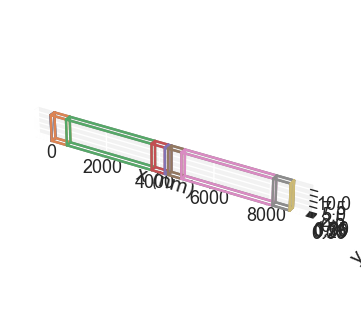

In [190]:
system_region.mesh.mpl.subregions(figsize=(4, 4),
                                  multiplier=1e-9,
                                  box_aspect=(40, 1, 4),
                                  show_region=True)

## 1.4. Boundary conditions

In [191]:
system_region.mesh.bc = 'x'

evolver_fixed_spins_list = ['']#['fixedLhs', 'fixedRhs']

In [192]:
if any(evolver_fixed_spins_list) and system_region.mesh.bc:
    raise ValueError("[evolver_fixed_spins_list] and [system_region.mesh.bc] cannot both be specified")


# 2. Define the system's starting magnetisation state

## 2.1. Saturisation magnetisation, $M_{s}$

In [193]:
sat_mag = 8e5  # [A/m]

In [194]:
json_params['Saturation magnetisation [A/m]'] = str(sat_mag)

## 2.2. (As needed) Create a mask for the magnetisation of the primary region

Create a mask for the primary region. Cells where $M_{s} = 0$ will be treated as non-magnetic **only if** we pass `valid='norm'` as an argument when defining `system.m`.

If `valid='norm'` is not used, then we must ensure that all other definitions, such as the regions defining $\mathbf{m}_\text{0}$ **exactly** match those used in the mask for $M_{s}$. In this example, failure to do so would lead to cells being initialised with unnormalised magnetisations. This almost always leads to garbage, and can be a very subtle error to debug.

In [195]:
def sat_mag_func(pos):
    valid_regions = [system_region.main.region]

    if any(pos in region for region in valid_regions):
        return sat_mag
    else:
        return 0.0

## 2.3. Initial magnetisation, $\mathbf{m}_{0}$

In [196]:
def m_init_func(pos):
    valid_regions = [system_subregions.fixedLhs.region, system_subregions.fixedRhs.region]

    if any(pos in region for region in valid_regions):
        return (0.0, 0.0, 1.0)
    else:
        return (0.0, 0.0, 1.0)

## 2.4. Define the system's magnetisation field

In [197]:
system.m = df.Field(
    mesh=system_region.mesh,
    value=m_init_func,
    norm=sat_mag,
    #valid='norm',
    nvdim=3
)

> From this point on temporary containers such as `system_region` are no longer needed. We can now use the `system` container to access the mesh, regions, and subregions. It is a good idea to remove these temporary containers to avoid confusion. The only real use-case for these containers later in the code is to check that `system` has been correctly updated.

# 3. Define the energy equation

We will define the energy equation for our micromagnetic system in Ubermag's container `micromagneticmodel.Energy()`.

> Ensure that variable names are descriptive and key-search friendly. When errors occur Ubermag, OOMMF, and Python messages are spewed out together; debugging is nightmare. This is why `sat_mag` is used instead of `Ms`.




In [198]:
system.energy = 0

## 3.1. Quick access

To save scrolling deep into the Notebook, I like to forward declare my core material parameters.

Not yet implemented properly; temporary solution below.

In [199]:
import dataclasses
@dataclasses.dataclass
class EnableEnergyTerm:
    anisotropy: bool = False
    demag: bool = False
    dmi: dict = dataclasses.field(default_factory=dict)
    driving_zeeman: bool = False
    exchange: bool = False
    static_zeeman: bool = False

    def __post_init__(self):
        if not self.dmi.get('constant'):
            self.dmi['constant'] = False
        if not self.dmi.get('dict'):
            self.dmi['dict'] = False
        if not self.dmi.get('subregions'):
            self.dmi['subregions'] = False

In [200]:
has_energy = EnableEnergyTerm(
    anisotropy=False,
    demag=True,
    driving_zeeman=True,
    exchange=True,
    static_zeeman=True
)

has_energy.dmi['subregions'] = True

## 3.2. Static Zeeman field

In [201]:
zeeman_static_strength = [0.0, 0.0, 0.30]  # [T]
zeeman_static_strength = convert_field_units.ampere_per_metre(zeeman_static_strength)

In [202]:
if has_energy.static_zeeman:
    system.energy += mm.Zeeman(H=zeeman_static_strength,
                               name='static')

## 3.3. Driving Zeeman field

In [203]:
driving_field_freq = 12.00 * 1e9

# Stepsize at which equations are evaluated
stepsize = 1e-12  # [s]

driving_field_strength = [1e-3, 0, 0]  # [T]

In [204]:
driving_field_strength = convert_field_units.ampere_per_metre(list(driving_field_strength))

json_params['h0_x [A/m]'] = str(driving_field_strength[0])
json_params['h0_y [A/m]'] = str(driving_field_strength[1])
json_params['h0_z [A/m]'] = str(driving_field_strength[2])

If not already set, then we now define where the line antennae are positioned. Update meshes, and print new mesh to visually check change(s).

### 3.3.1. Strength of the driving field

For true control over the implementation of $\mathbf{h}_\text{d}$ we must define a customised field (`df.Field`). This determines whether a cell is located in a driven region.

In [205]:
def h0_func(pos):
    if pos in system_subregions.driven.region:
        return driving_field_strength

    return (0, 0, 0)  # No drive outside these regions

We can now create a field for $\mathbf{h}_\text{d}$, and add it to the respective energy term.

In [206]:
h0_field = df.Field(mesh=system.m.mesh,
                    nvdim=3,
                    value=h0_func)

If you are using `tcl_strings` then you **must** ensure that `mm.Zeeman.name` is identical to the name passed to the tcl script.

In [207]:
energy_zeeman_drive = mm.Zeeman(H=h0_field,
                                name='pump',
                                func='sin',
                                f=driving_field_freq,
                                t0=0*stepsize)

## 3.4. Dzyaloshinskii-Moriya interaction (DMI)

In [208]:
D_ij = 2.5e-3 # [J/m^2]

D_ij_gradient = {'chain': D_ij / 2, 'driven': D_ij, 'lower': D_ij / 2, 'upper': D_ij}
dmi_subregion_mapping = {}

In [209]:
json_params['D_ij [J/m^2]'] = D_ij_gradient['driven']
json_params['has_energy.dmi.constant'] = has_energy.dmi['constant']
json_params['has_energy.dmi.dict'] = has_energy.dmi['dict']
json_params['has_energy.dmi.subregions'] = has_energy.dmi['subregions']

### 3.4.1. Option to manually define DMI for each region

In [210]:
def generate_dmi_dict(region_with_subregions: csp.MyRegions):

    dmi_region = {}
    dmi_subregions = {key : D_ij for key in region_with_subregions.subregions.keys()}

    last_region_seen = 'entire'


    for key in dmi_subregions.keys():
        dmi_region[f'{last_region_seen}:{key}'] = D_ij
        last_region_seen = key
        dmi_region[key] = D_ij
    dmi_region[f'{last_region_seen}:entire'] = D_ij

    return dmi_region

In [211]:
if has_energy.dmi['dict']:
    dmi_regions = {key: D_ij_gradient['chain'] for key in system_subregions.subregions.keys()}

    dmi_subregion_mapping = csp.add_inter_subregion_values(dmi_regions,
                                                           dmi_chain_left=D_ij_gradient['chain'],
                                                           dmi_chain_right=D_ij_gradient['chain']
                                                           )
    json_params['D_ij (chain) [J/m^2]'] = D_ij_gradient['chain']
    json_params['D_ij (driven) [J/m^2]'] = D_ij_gradient['driven']


Manually set specific subregions' DMI values.

In [212]:
if has_energy.dmi['dict']:
    dmi_subregion_mapping['gradientLhs:driven'] = D_ij_gradient['driven'] / 4
    dmi_subregion_mapping['driven'] = D_ij_gradient['driven']
    dmi_subregion_mapping['driven:gradientRhs'] = D_ij_gradient['driven'] / 4

### 3.4.2. Option to apply gradients to region(s) with DMI

In [213]:
num_dmi_subdivisions = 10

Make sure to update the JSON with these values as the MIF file will be difficult to read.

In [214]:
if has_energy.dmi['subregions']:
    for key, value in D_ij_gradient.items():
        json_params[key] = value

First we need to extract the DMI values for the subregions that have already been defined. We start with the left-hand side of the system. Note that we exclude the gradientLhs subregion itself.

In [215]:
dmi_lhs_before_gradient = {}

if has_energy.dmi['subregions']:
    for key in system_subregions.subregions.keys():
        if key == 'gradientLhs':
            break
        dmi_lhs_before_gradient[key] = D_ij_gradient['chain']

Now we move to create a dictionary for the right-hand side of the system.

In [216]:
dmi_rhs_after_gradient = {}

if has_energy.dmi['subregions']:
    append_to_dmi_rhs = False
    for key in system_subregions.subregions.keys():
        if key == 'gradientRhs':
            append_to_dmi_rhs = True
            continue
        if append_to_dmi_rhs:
            dmi_rhs_after_gradient[key] = D_ij_gradient['chain']

We are now able to begin discretising the gradient regions to fake a DMI field. We start with the left-hand size.

In [217]:
dmi_lhs_mapping = {}
if has_energy.dmi['subregions']:
    system_subregions.gradientLhs.cell = system_prop.cell
    system_subregions.gradientLhs.dims = (num_dmi_subdivisions, 1, 1)

    dmi_lhs_mapping, dmi_lhs_subregions = csp.subdivide_region(system_subregions,
                                                               system_subregions.gradientLhs,
                                                               value_min=D_ij_gradient['lower'],
                                                               value_max=D_ij_gradient['upper'],
                                                               compatible_discretisation=True,
                                                               subregion_name_root='dmiLhsGrad',
                                                               n_subdivisions=num_dmi_subdivisions,
                                                               axis='x',
                                                               parent_key='gradientLhs',
                                                               remove_parent=True)

Make sure to include the DMI value within the driving region!

In [218]:
dmi_center = {}
if has_energy.dmi['subregions']:
    dmi_center = {system_subregions.driven.name: D_ij_gradient['driven']}

Now the DMI values for the right-hand side gradient region.

In [219]:
dmi_rhs_mapping = {}
if has_energy.dmi['subregions']:
    system_subregions.gradientRhs.cell = system_prop.cell
    system_subregions.gradientRhs.dims = (num_dmi_subdivisions, 1, 1)

    dmi_rhs_mapping, dmi_rhs_subregions = csp.subdivide_region(system_subregions,
                                                               system_subregions.gradientRhs,
                                                               value_min=D_ij_gradient['upper'],
                                                               value_max=D_ij_gradient['lower'],
                                                               compatible_discretisation=True,
                                                               subregion_name_root='dmiRhsGrad',
                                                               n_subdivisions=num_dmi_subdivisions,
                                                               axis='x',
                                                               parent_key='gradientRhs',
                                                               remove_parent=True)

This is the main trick! By adding the dictionaries as arguments to `csp.add_inter_subregion_values` in the correct order we can automatically generate a dictionary in the form required by Ubermag.

In [220]:
if has_energy.dmi['subregions']:
    dmi_subregion_mapping = csp.add_inter_subregion_values(dmi_lhs_before_gradient,
                                                           dmi_lhs_mapping,
                                                           dmi_center,
                                                           dmi_rhs_mapping,
                                                           dmi_rhs_after_gradient,
                                                           dmi_chain_left=D_ij_gradient['chain'],
                                                           dmi_chain_right=D_ij_gradient['chain'])

### 3.4.3. Check DMI flags and include energy term

In [221]:
# Build the symmetric version:
D_complete = {}
for key, val in dmi_subregion_mapping.items():
    D_complete[key] = val
    if ':' in key:
        a, b = key.split(':', 1)
        D_complete[f'{b}:{a}'] = val

dmi_subregion_mapping = D_complete

if has_energy.dmi['constant']:
    system.energy += mm.DMI(D=D_ij,
                            crystalclass='Cnv_y')
elif has_energy.dmi['dict']:
    system.energy += mm.DMI(D=dmi_subregion_mapping,
                            crystalclass='Cnv_y')
elif has_energy.dmi['subregions']:

    system.energy += mm.DMI(D=D_complete,
                        crystalclass='Cnv_y')

    #system_region.mesh.subregions = system_subregions.subregions
    # system_region.mesh = df.Mesh(region=system_region.main.region,
    #                              cell=system_prop.cell,
    #                              subregions=system_subregions.subregions)
    system.m.mesh.subregions = system_subregions.subregions
    # system.m = df.Field(
    #     mesh=system_region.mesh,
    #     value=m_init_func,
    #     norm=sat_mag,
    #     #valid='norm',
    #     nvdim=3
    # )
else:
    raise ValueError('DMI not set as constant, dict, or subregions. Please check your code.')

In [222]:
system.energy.dmi.D

{'entire:fixedLhs': 0.00125,
 'fixedLhs:entire': 0.00125,
 'fixedLhs': 0.00125,
 'fixedLhs:dampingLhs': 0.0013,
 'dampingLhs:fixedLhs': 0.0013,
 'dampingLhs': 0.00125,
 'dampingLhs:freeLhs': 0.0013,
 'freeLhs:dampingLhs': 0.0013,
 'freeLhs': 0.00125,
 'freeLhs:dmiLhsGrad0': 0.0012,
 'dmiLhsGrad0:freeLhs': 0.0012,
 'dmiLhsGrad0': 0.0012,
 'dmiLhsGrad0:dmiLhsGrad1': 0.0013,
 'dmiLhsGrad1:dmiLhsGrad0': 0.0013,
 'dmiLhsGrad1': 0.0014,
 'dmiLhsGrad1:dmiLhsGrad2': 0.0014,
 'dmiLhsGrad2:dmiLhsGrad1': 0.0014,
 'dmiLhsGrad2': 0.0015,
 'dmiLhsGrad2:dmiLhsGrad3': 0.0016,
 'dmiLhsGrad3:dmiLhsGrad2': 0.0016,
 'dmiLhsGrad3': 0.0017,
 'dmiLhsGrad3:dmiLhsGrad4': 0.0017,
 'dmiLhsGrad4:dmiLhsGrad3': 0.0017,
 'dmiLhsGrad4': 0.0018,
 'dmiLhsGrad4:dmiLhsGrad5': 0.0018,
 'dmiLhsGrad5:dmiLhsGrad4': 0.0018,
 'dmiLhsGrad5': 0.0019,
 'dmiLhsGrad5:dmiLhsGrad6': 0.002,
 'dmiLhsGrad6:dmiLhsGrad5': 0.002,
 'dmiLhsGrad6': 0.0021,
 'dmiLhsGrad6:dmiLhsGrad7': 0.0022,
 'dmiLhsGrad7:dmiLhsGrad6': 0.0022,
 'dmiLhsGrad7':

### 3.4.4. Check for chiral texture

Our larger dispersion relations' proven validity is predicated on the DMI not being strong enough to alter the ground  of the magnetic configuration. This is because the ground state is no longer a single magnetic domain, and instead a magnetic texture.

Note that our dispersion relations **may** remain valid even if this condition fails, but this is not guaranteed. Suggested fixes include reducing the strength of `D_ij`, or increasing the thickness of the system along its symmetry-breaking axis.

> This equation is marked Eq. (20) in the paper *moon2013spin*.

In [223]:
D_ij_threshold = np.sqrt(
    ((2 * 1.3e-11) / (mm.consts.mu0 * sat_mag))
    * (2 * max(zeeman_static_strength)
     + sat_mag
     + 2 * np.sqrt(
                max(zeeman_static_strength)
                * (max(zeeman_static_strength) + sat_mag)
            )
     )
)

print(f"DMI threshold: {D_ij_threshold:.2e} J/m^2. True when A = {1.3e-11}")

DMI threshold: 7.67e-03 J/m^2. True when A = 1.3e-11


In [224]:
if ((2 * D_ij) / (mm.consts.mu0 * sat_mag)) > D_ij_threshold:
    raise ValueError(f"The DM interaction was set as {D_ij} [J/m^2], "
                     f"but the DMI threshold is {D_ij_threshold} J/m^2.")


## 3.5. Heisenberg exchange interaction

In [225]:
exchange_stiffness = 1.3e-11 # [J/m]

In [226]:
if has_energy.exchange:
    system.energy += mm.Exchange(A=exchange_stiffness)

### 3.5.1. Check the exchange length

Check if the selected cell and system dimensions are appropriate for the exchange length and helical length. Failed tests should prevent the simulation from running.

In [227]:
# Temporary check to catch a common mistake of mine during these simulations
if system_prop.cell[0] != 1e-9 and exchange_stiffness == 1.3e-11:
    raise ValueError('Exchange stiffness has likely not been rescaled; your cell size along the x-axis is not 1 nanometer! Was this intentional?')

In [228]:
exchange_length = np.sqrt((2 * exchange_stiffness) / (mm.consts.mu0 * sat_mag ** 2))

helical_length = (4 * np.pi * exchange_stiffness) / np.abs(D_ij) if D_ij != 0 else np.NZERO

print(f"Exchange length: {exchange_length * 1e9:.2f} nm",
      f"\nHelical length: {helical_length * 1e9:.2f} nm",
      f"\nMax cell length: {system_prop.cell[0] * 1e9 * 5:.2f} nm")

if exchange_length < system_prop.cell[0] * 5:
    raise ValueError('Exchange length is less than five times the cell size!')

if helical_length >= system_prop.length:
    raise ValueError('Helical length is greater than the system length!')

Exchange length: 5.69 nm 
Helical length: 65.35 nm 
Max cell length: 5.00 nm


## 3.6. Dipole-dipole interaction (demag)

In [229]:
if has_energy.demag:
    system.energy += mm.Demag()#asymptotic_radius=16)

## 3.7. Uniaxial anisotropy

In [230]:
K_1 = 6.2e4  # [J/m^3]
K_2 = 0e5  # [J/m^3]

# anisotropy axis
aniso_axis = (0, 0, 1)

In [231]:
if has_energy.anisotropy:
    system.energy += mm.UniaxialAnisotropy(K1=K_1,
                                           K2=K_2,
                                           u=aniso_axis)

## 3.8. Check our energy equation

In [232]:
system.energy

Zeeman(H=(0.0, 0.0, 238732.414637843)) + DMI(D={'entire:fixedLhs': 0.00125, 'fixedLhs:entire': 0.00125, 'fixedLhs': 0.00125, 'fixedLhs:dampingLhs': 0.0013, 'dampingLhs:fixedLhs': 0.0013, 'dampingLhs': 0.00125, 'dampingLhs:freeLhs': 0.0013, 'freeLhs:dampingLhs': 0.0013, 'freeLhs': 0.00125, 'freeLhs:dmiLhsGrad0': 0.0012, 'dmiLhsGrad0:freeLhs': 0.0012, 'dmiLhsGrad0': 0.0012, 'dmiLhsGrad0:dmiLhsGrad1': 0.0013, 'dmiLhsGrad1:dmiLhsGrad0': 0.0013, 'dmiLhsGrad1': 0.0014, 'dmiLhsGrad1:dmiLhsGrad2': 0.0014, 'dmiLhsGrad2:dmiLhsGrad1': 0.0014, 'dmiLhsGrad2': 0.0015, 'dmiLhsGrad2:dmiLhsGrad3': 0.0016, 'dmiLhsGrad3:dmiLhsGrad2': 0.0016, 'dmiLhsGrad3': 0.0017, 'dmiLhsGrad3:dmiLhsGrad4': 0.0017, 'dmiLhsGrad4:dmiLhsGrad3': 0.0017, 'dmiLhsGrad4': 0.0018, 'dmiLhsGrad4:dmiLhsGrad5': 0.0018, 'dmiLhsGrad5:dmiLhsGrad4': 0.0018, 'dmiLhsGrad5': 0.0019, 'dmiLhsGrad5:dmiLhsGrad6': 0.002, 'dmiLhsGrad6:dmiLhsGrad5': 0.002, 'dmiLhsGrad6': 0.0021, 'dmiLhsGrad6:dmiLhsGrad7': 0.0022, 'dmiLhsGrad7:dmiLhsGrad6': 0.0022,

# 4. Define the dynamics equation

In [233]:
system.dynamics = 0

## 4.1. Gilbert damping

In [234]:
alpha_bulk = 0.001
alpha_driven = 0.01
alpha_interfacial = 0.01

In [235]:
json_params['alpha_bulk'] = str(alpha_bulk)
json_params['alpha_driven'] = str(alpha_driven)
json_params['alpha_interfacial'] = str(alpha_interfacial)

In [236]:
alpha_dict = {}
for key in dmi_subregion_mapping.keys():
    if ':' not in key:
        alpha_dict[key] = 0.0

In [237]:
for key, val in alpha_dict.items():
    if 'driven' in key:
        alpha_dict[key] = alpha_driven
    elif 'gradient' in key:
        alpha_dict[key] = (alpha_driven + alpha_bulk) / 2
    else:
        alpha_dict[key] = alpha_bulk

In [238]:
alpha_func = dar.AlphaABC(alpha_bulk=alpha_bulk,
                          alpha_driven=alpha_driven,
                          system_prop=system_prop,
                          system_subregions=system_subregions)

In [239]:
alpha_field = df.Field(mesh=system_region.mesh,
                       nvdim=1,
                       value=alpha_func)

In [240]:
system.dynamics += mm.Damping(alpha=alpha_dict)

### 4.1.1. Checks

In [241]:
if system.m.mesh.bc:
    if isinstance(system.dynamics.damping.alpha, df.field.Field):
        raise ValueError(f"The damping field is a function of position, but the mesh has periodic boundary conditions. This may be an error!")

elif any(evolver_fixed_spins_list):
    if isinstance(system.dynamics.damping.alpha, float | int):
        raise ValueError(f'The damping field is a constant value of {system.dynamics.damping.alpha}, but the mesh does not have periodic boundary conditions. This is likely an error!')

## 4.2. Precession

Gyromagnetic ratio, $\gamma_{0}$.

If value is provided here then one MUST use gamma_G (not gamma_LL) when defining subsequent evolvers

In [242]:
gamma0 = 28.2e9 * 2 * np.pi  # [rad*Hz/T]

In [243]:
system.dynamics += mm.Precession(gamma0=gamma0*mm.consts.mu0)

## 4.3. Check our expression

In [244]:
system.dynamics

Damping(alpha={'fixedLhs': 0.001, 'dampingLhs': 0.001, 'freeLhs': 0.001, 'dmiLhsGrad0': 0.001, 'dmiLhsGrad1': 0.001, 'dmiLhsGrad2': 0.001, 'dmiLhsGrad3': 0.001, 'dmiLhsGrad4': 0.001, 'dmiLhsGrad5': 0.001, 'dmiLhsGrad6': 0.001, 'dmiLhsGrad7': 0.001, 'dmiLhsGrad8': 0.001, 'dmiLhsGrad9': 0.001, 'driven': 0.01, 'dmiRhsGrad0': 0.001, 'dmiRhsGrad1': 0.001, 'dmiRhsGrad2': 0.001, 'dmiRhsGrad3': 0.001, 'dmiRhsGrad4': 0.001, 'dmiRhsGrad5': 0.001, 'dmiRhsGrad6': 0.001, 'dmiRhsGrad7': 0.001, 'dmiRhsGrad8': 0.001, 'dmiRhsGrad9': 0.001, 'freeRhs': 0.001, 'dampingRhs': 0.001, 'fixedRhs': 0.001}) + Precession(gamma0=222658.2752885759)

# 5. Relaxation

## 5.1. Drive the system

### 5.1.1. Define the minimisation evolver

In [245]:
min_evolver = oc.CGEvolver(method='Polak-Ribiere',
                           fixed_spins=evolver_fixed_spins_list,
                           #energy_precision=1e-10  # May need to increase for large systems
                           )

minD = oc.MinDriver(evolver=min_evolver,
                    stopping_mxHxm=0.1
                    )

### 5.1.2. Apply the `TimeDriver`

In [246]:
minD.drive(system,
           dirname=data_output,
           fixed_subregions=evolver_fixed_spins_list,
           verbose=2
           )

Running OOMMF (TclOOMMFRunner)[2025/04/17 14:19]... (0.6 s)


## 5.2. Display and save the output

In [247]:
%%capture
cip.default_three_pane(system=system,
                       system_prop=system_prop,
                       system_region=system_region,
                       figs_output_dir=figs_output,
                       drive_number=system.drive_number,
                       fig_name='after_relaxation',
                       has_schematic=False,
                       #scalar_resample_shape=[256, 3],
                       # vector_resample_shape=[16, 3]
                       )

# 6. Drive the system with the time-dependent field

## 6.1. Set temporal parameters

In [248]:
# Maximum time for simulation
tmax = 10e-9  # [s]

# num_datapoints = round(tmax / stepsize)  # Warning: can lead to very large output files!
num_datapoints = 400

# Spacing between saved outputs
stepsize_between_datapoints = tmax / num_datapoints

## 6.2. Add time-dependent fields to the energy equation

In [249]:
if has_energy.driving_zeeman:
    system.energy += energy_zeeman_drive

### 6.2.1. Check the energy equation

In [250]:
system.energy

Zeeman(H=(0.0, 0.0, 238732.414637843)) + DMI(D={'entire:fixedLhs': 0.00125, 'fixedLhs:entire': 0.00125, 'fixedLhs': 0.00125, 'fixedLhs:dampingLhs': 0.0013, 'dampingLhs:fixedLhs': 0.0013, 'dampingLhs': 0.00125, 'dampingLhs:freeLhs': 0.0013, 'freeLhs:dampingLhs': 0.0013, 'freeLhs': 0.00125, 'freeLhs:dmiLhsGrad0': 0.0012, 'dmiLhsGrad0:freeLhs': 0.0012, 'dmiLhsGrad0': 0.0012, 'dmiLhsGrad0:dmiLhsGrad1': 0.0013, 'dmiLhsGrad1:dmiLhsGrad0': 0.0013, 'dmiLhsGrad1': 0.0014, 'dmiLhsGrad1:dmiLhsGrad2': 0.0014, 'dmiLhsGrad2:dmiLhsGrad1': 0.0014, 'dmiLhsGrad2': 0.0015, 'dmiLhsGrad2:dmiLhsGrad3': 0.0016, 'dmiLhsGrad3:dmiLhsGrad2': 0.0016, 'dmiLhsGrad3': 0.0017, 'dmiLhsGrad3:dmiLhsGrad4': 0.0017, 'dmiLhsGrad4:dmiLhsGrad3': 0.0017, 'dmiLhsGrad4': 0.0018, 'dmiLhsGrad4:dmiLhsGrad5': 0.0018, 'dmiLhsGrad5:dmiLhsGrad4': 0.0018, 'dmiLhsGrad5': 0.0019, 'dmiLhsGrad5:dmiLhsGrad6': 0.002, 'dmiLhsGrad6:dmiLhsGrad5': 0.002, 'dmiLhsGrad6': 0.0021, 'dmiLhsGrad6:dmiLhsGrad7': 0.0022, 'dmiLhsGrad7:dmiLhsGrad6': 0.0022,

## 6.3. Drive the system

### 6.3.1. Define the evolver

In [251]:
sim_evolver = oc.RungeKuttaEvolver(method='rkf54',
                                   #alpha=alpha,  # Do not supply `alpha` here if already defined in `system.dynamics`
                                   #gamma_G=gamma0*mm.consts.mu0,
                                   # Driver may override timestep conditions if stopping_criteria are given
                                   #min_timestep=0,  # Default: zero.
                                   #max_timestep=stepsize,  # Default: 1e-10 [s].
                                   fixed_spins=evolver_fixed_spins_list,
                                   do_precess=1,
                                   #energy_precision=1e-10,  # May need to increase for large systems
                                   allow_signed_gamma=0,
                                   )

td = oc.TimeDriver(evolver=sim_evolver)

### 6.3.2. Apply the `TimeDriver`

It's at this point we pass our JSON parameters to the driver.

In [252]:
td.drive(system,
         t=tmax,
         dirname=data_output,
         n=num_datapoints,
         n_threads=10,
         fixed_subregions=evolver_fixed_spins_list,
         verbose=2,
         **json_params
         )

Running OOMMF (TclOOMMFRunner):   0%|          | 0/400 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2025/04/17 14:19] took 1248.8 s


## 6.4. Display and save the output

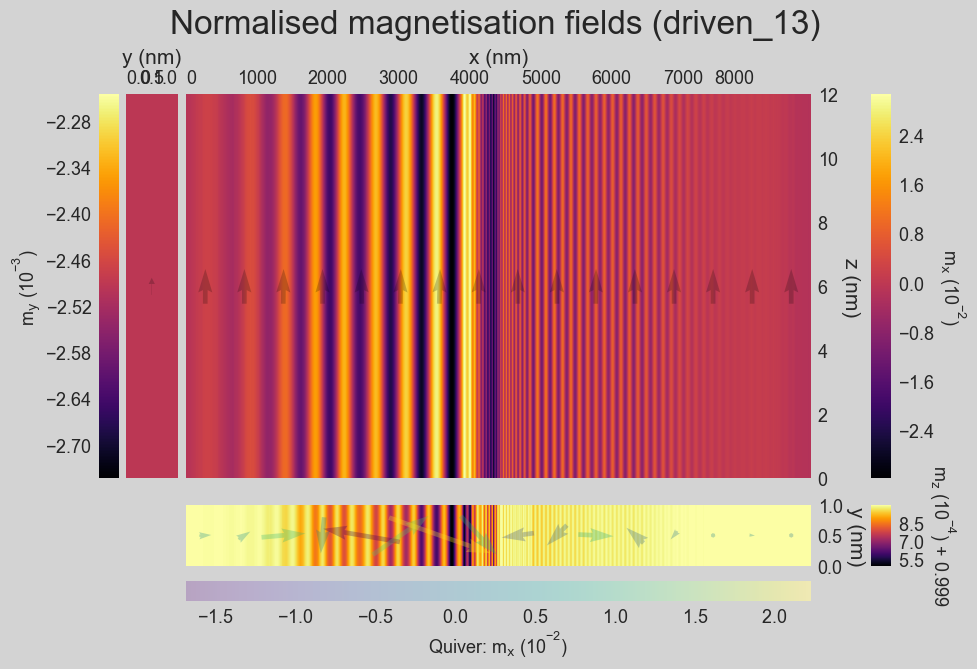

In [253]:
cip.default_three_pane(system=system,
                       system_prop=system_prop,
                       system_region=system_region,
                       figs_output_dir=figs_output,
                       drive_number=system.drive_number - 1,
                       fig_name=f'driven_{system.drive_number - 1}',
                       has_schematic=False)

## 6.5. Breakpoint

Pause here to check the initial data outputs before completing more advanced post-processing.

This is also an appropriate place to add temporary debug lines to the code. Note that these should be deleted after debugging is complete.

In [254]:
# Cell which acts as a breakpoint; 0/0 intentionally produces an error. Alternative is to utilise the 'raise' keyword
raise ValueError('Breakpoint')

ValueError: Breakpoint

# 7. Post-processing

## 7.1. Import data

In [ ]:
try:
    system.name
except NameError:
    system = mm.System(name='dmi_paper_validation')
    system.drive_number = 4

In [ ]:
m_all_data = md.Drive(name=system.name, dirname=data_output,
                      number=system.drive_number - 1, use_cache=True)

## 7.2. Extract required values while handling NameErrors

In [ ]:
try:
    system_prop
except NameError:

    system_prop = csp.SystemProperties(length=m_all_data.m0.mesh.region.pmax[0],
                                       width=m_all_data.m0.mesh.region.pmax[1],
                                       thickness=m_all_data.m0.mesh.region.pmax[2])

    # System mesh cell size
    system_prop.cell = tuple(m_all_data.m0.mesh.cell)
    system_prop.units = m_all_data.m0.mesh.region.units
    system_prop.update_numcells()

try:
    sat_mag
except NameError:
    sat_mag = float(m_all_data.info['Saturation magnetisation [A/m]'])

try:
    stepsize_between_datapoints
except NameError:
    stepsize_between_datapoints = m_all_data.table.data.t[0]


In [ ]:
data_m0 = m_all_data.m0.to_xarray().values

m_pos = [int(round(system_prop.width * 0.5 / system_prop.cell[1], 0)),
         int(round(system_prop.thickness * 0.5 / system_prop.cell[2], 0))]

data_mx0 = data_m0[:, m_pos[0], m_pos[1], 0] / sat_mag
data_my0 = data_m0[:, m_pos[0], m_pos[1], 1] / sat_mag
data_mz0 = data_m0[:, m_pos[0], m_pos[1], 2] / sat_mag

data_mx = np.zeros((m_all_data.n, int(system_prop.numcells[0])))
data_my = np.zeros((m_all_data.n, int(system_prop.numcells[0])))
data_mz = np.zeros((m_all_data.n, int(system_prop.numcells[0])))

m_data = m_all_data.to_xarray()

for i, _ in enumerate(m_data):
    data_mx[i] = (m_data[i, :, m_pos[0], m_pos[1], 0].values / sat_mag) - data_mx0
    data_my[i] = (m_data[i, :, m_pos[0], m_pos[1], 1].values / sat_mag) - data_my0
    data_mz[i] = (m_data[i, :, m_pos[0], m_pos[1], 2].values / sat_mag) - data_mz0

In [ ]:
%%capture
# Prepare the meshgrid for 3D plot
x = np.linspace(0, system_prop.length, data_mx.shape[1])
z = np.linspace(0, system_prop.thickness, data_mx.shape[0])
X, Z = np.meshgrid(x, z)
Y = np.ones_like(X) * system_prop.width / 2  # y is fixed slice

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y,
                       data_mx,
                       cmap='viridis')  # data_mx as example

# Add color bar to indicate the scale
fig.colorbar(surf)

# Customize the view angle
ax.view_init(elev=30, azim=120)

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Width')
ax.set_zlabel('Magnetization')

## 7.3. Temporal evolution of the system

In [ ]:
time_index = min(500, data_mx.shape[0])
plt.plot(np.arange(0, system_prop.numcells[0] * (system_prop.cell[0] / 1e-9), system_prop.cell[0] / 1e-9),
         data_mx[time_index-1, :], alpha=0.8, color='C1', label='OOMMF')
#my_pos_times, my_pos_vals = np.loadtxt('/Users/cameronmceleney/pCloud Drive/test/data_se.txt')
#plt.plot(my_pos_times, my_pos_vals[::-1], zorder=0.9, label='C++', color='C4')
plt.gca().set(title=f'Drive: {m_all_data.info['drive_number']} | Time: {time_index * stepsize_between_datapoints / 1e-9: .3f} ns',
              xlim=(1, system_prop.length * 1e9),
              #ylim=(-0.015, 0.015),
              xlabel='Distance (nm)', ylabel='Amplitude (a.u.)')
plt.legend()
plt.savefig(figs_output + '/drive-' + str(m_all_data.number) + f'_pos_{int(time_index * stepsize_between_datapoints * 1e9)}ns.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
 # Cell which acts as a breakpoint; 0/0 intentionally produces an error. Alternative is to utilise the 'raise' keyword
#raise ValueError('Breakpoint')

## 7.4. Spatial evolution of the system

In [ ]:
pos_index_1 = 3600
pos_index_2 = system_prop.numcells[0] - 1 - pos_index_1
plt.plot(np.linspace(0, tmax-stepsize, num_datapoints)*1e9, data_mx[:, pos_index_1], alpha=0.8, color='C1', label=f'{pos_index_1: .0f}')
plt.plot(np.linspace(0, tmax-stepsize, num_datapoints)*1e9, data_mx[:, pos_index_2], alpha=0.8, color='C4', label=f'{pos_index_2: .0f}')

#my_times, my_vals = np.loadtxt('/Users/cameronmceleney/pCloud Drive/test/data.txt')
#plt.plot(my_times[:], my_vals, zorder=0.9, color='C4', label='C++')
plt.gca().set(title=f'Drive: {m_all_data.number}', xlim=(0, 5),
              xlabel='Time (ns)', ylabel='Amplitude (a.u.)')
plt.legend(title='Site from\nLHS (nm)')

plt.savefig(figs_output + '/drive-' + str(m_all_data.number) + f'_time_{pos_index_1}nm.png', dpi=300, bbox_inches='tight')

## Dispersion relation

In [ ]:
def Omega_generalised_with_ua(system_prop, H0, Ms, A, D, k, d, K1, K2, aniso_axis, gamma, p=1,
                              has_demag=1, has_dmi=1, has_aniso=1):
    J = 2 * A / (mm.consts.mu0 * Ms)
    DM = -2 * D / (mm.consts.mu0 * Ms)

    demag_factors = cpe.calculate_demag_factor_uniform_prism(system_prop.length - 2 * d,
                                                             system_prop.width,
                                                             system_prop.thickness)
    # print(demag_factors)

    #om = np.sqrt((H0 + J * (k ** 2) + has_demag * Ms * (demag_factors['N_x'] - demag_factors['N_z']))
    #             * (H0 + J * (k ** 2) + has_aniso * ((4 * (aniso_axis[2] ** 2)) / (Ms * mm.consts.mu0)
    #                                                 * (1 * K1 + 2 * K2 * (aniso_axis[2] ** 2)))
    #                + has_demag * Ms * (demag_factors['N_y'] - demag_factors['N_z'])
    #                )
    #             + has_aniso * (4 * (aniso_axis[2] ** 4)) / (Ms ** 2 * mm.consts.mu0 ** 2)
    #             * (4 * (K1**2) + 4 * K1 * K2 * (aniso_axis[2] ** 2) + 4 * (K2 ** 2) * (aniso_axis[2] ** 4))
    #             )
    om = np.sqrt((H0
                  + J * (k ** 2)
                  + has_aniso * ((2 * (aniso_axis[2] ** 2)) / (Ms * mm.consts.mu0) * (1 * K1 + 2 * K2 * (aniso_axis[2] ** 2)))
                  + has_demag * Ms * (demag_factors['N_x'] - demag_factors['N_z']))
                 * (H0
                    + J * (k ** 2)
                    + has_aniso * ((2 * (aniso_axis[2] ** 2)) / (Ms * mm.consts.mu0) * (1 * K1 + 2 * K2 * (aniso_axis[2] ** 2)))
                    + has_demag * Ms * (demag_factors['N_y'] - demag_factors['N_z'])
                )
             )

    om += has_dmi * p * DM * k

    # the mu0 factor shown in the paper is not necessary if we use gamma
    # in Hz / (A / m)
    om *= (gamma * mm.consts.mu0)

    return om

In [ ]:
kmax = 0.8 * 1e9
ks = np.linspace(1e-10, kmax, int(round(system_prop.numcells[0] / 2)))
ks_n = np.linspace(-kmax, 1e-10, int(round(system_prop.numcells[0] / 2)))

# Moon Eq. (12)
#oms = cdr.Omega_Moon(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_n = cdr.Omega_Moon(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#
## Moon Eq. (14)
#oms_l = cdr.Omega_Moon_large_k(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_l_n = cdr.Omega_Moon_large_k(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#
## Moon Eq. (16)
#oms_s = cdr.Omega_Moon_small_k(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_s_n = cdr.Omega_Moon_small_k(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#
## Custom dispersion relation
#oms_c = cdr.Omega_Moon_custom(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_c_n = cdr.Omega_Moon_custom(zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)

# Custom dispersion relation
oms_g = cdr.Omega_generalised_with_ua(system_prop,
                                         zeeman_static_strength[2], sat_mag, exchange_stiffness, D_ij,
                                         ks, system_prop.cell[0],
                                         K_1, K_2, aniso_axis,
                                         gamma0 / (2 * np.pi * 1e9), p=1,
                                         has_demag=1, has_dmi=1, has_aniso=1)
oms_g_n = cdr.Omega_generalised_with_ua(system_prop,
                                           zeeman_static_strength[2], sat_mag, exchange_stiffness, D_ij,
                                           ks_n, system_prop.cell[0],
                                           K_1, K_2, aniso_axis,
                                           gamma0 / (2 * np.pi * 1e9), p=1,
                                           has_demag=1, has_dmi=1, has_aniso=1)

times = m_data['t'].values
x = m_data['x'].values

# Create Hanning windows
times_filter = np.hanning(len(times))
x_filter = np.hanning(len(x))

# Apply the Hanning window to the data
window = np.outer(times_filter, x_filter)
data_mx_windowed = data_mx * window

fft_data = np.fft.fft2(data_mx_windowed)
fft_data = abs(np.fft.fftshift(fft_data))
log_fft_data = np.log10(fft_data**2)

freqs = np.fft.fftfreq(n=len(times), d=(times[1] - times[0])) * 1e-9
freqs = np.fft.fftshift(freqs)

k = np.fft.fftfreq(n=len(x), d=(x[1] - x[0])) * 1e-9
k = np.fft.fftshift(k) * 2 * np.pi

fig5, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(log_fft_data, extent=[k[0], k[-1], freqs[0], freqs[-1]],
          vmin=log_fft_data.min() / 10, vmax=log_fft_data.max(),
          aspect='auto', interpolation='none',
          cmap='magma')

#ax.plot(ks * 1e-9, oms, lw=2, ls='--', color='white', alpha=0.5, label='Theory (Moon)')
#ax.plot(ks_n * 1e-9, oms_n, lw=2, ls='--', alpha=0.5, color='white')

#ax.plot(ks * 1e-9, oms_l, lw=2, ls='-.', color='lightgreen', alpha=0.5, label='Theory (Large k)')
#ax.plot(ks_n * 1e-9, oms_l_n, lw=2, ls='-.', alpha=0.5, color='lightgreen')

#ax.plot(ks * 1e-9, oms_s, lw=2, ls='-.', color='orange', alpha=1, label='Theory (Small k)')
#ax.plot(ks_n * 1e-9, oms_s_n, lw=2, ls='-.', alpha=1, color='orange')

#ax.plot(ks * 1e-9, oms_c, lw=2, ls=':', color='lightblue', alpha=1, label='Theory (Custom)')
#ax.plot(ks_n * 1e-9, oms_c_n, lw=2, ls='-.', alpha=1, color='lightblue')

ax.plot(ks * 1e-9, oms_g, lw=2, ls='-.', color='yellow', alpha=0.75, label='Theory (Ubermag)')
ax.plot(ks_n * 1e-9, oms_g_n, lw=2, ls='-.', alpha=0.75, color='yellow')

# Load the arrays from the .npz file
#data = np.load('/Users/cameronmceleney/Data/2024-07-29/data.npz')
#ksc = data['ks']
#ksc_n = data['ks_n']
#omsc_g = data['oms_g']
#omsc_g_n = data['oms_g_n']

#ax.plot(ksc * 1e-9, omsc_g, ls='-.', color='purple', alpha=0.75, label='Theory (C++)')
#ax.plot(ksc_n * 1e-9, omsc_g_n, ls='-.', alpha=0.75, color='purple')

ax.set(xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Frequency, $f$ (GHz)',
       xlim=(-0.15, 0.15),
       ylim=(0, 40)
       )


#handles, labels = ax.get_legend_handles_labels()
#blacks = matplotlib.patches.Patch(color='purple', label='OOMMf')
#ax.legend(handles=[handles[0], blacks])
ax.legend(labelcolor='white')
plt.savefig(figs_output + '/drive-' + str(system.drive_number - 1) + '_dispersion_relation.png', dpi=300, bbox_inches='tight')


In [ ]:
fig_fft, fig_fft_axes = plt.subplot_mosaic(mosaic=[['k-space', 'k-space'],
                                          ['freq-space-lhs', 'freq-space-rhs']],
                                  figsize=(12, 8),
                                  gridspec_kw={'width_ratios': (1, 1),
                                               'height_ratios': (1, 1),
                                               'wspace': 0.0,
                                               'hspace': 0.0},
                                  layout='constrained',
                                  facecolor='lightgrey'
                                  )

fig_fft.suptitle(f'Drive: {m_all_data.number}', fontsize=20)

for i in range(1, int(tmax * 1e9)+1):
    fig_fft_axes['k-space'].plot(k, log_fft_data[i * 1000 - 1, :], label=f'{i}')
fig_fft_axes['k-space'].set(title=f'FFT across full spin chain',
              xlabel='Wavevector',
              ylabel='Amplitude (log)',
              xlim=[-0.2, 0.2])
fig_fft_axes['k-space'].legend(title='Sim. time (ns)', ncols=2)

for fft_pos_index in range(300, 2101, 300):
     fig_fft_axes['freq-space-lhs'].plot(freqs, log_fft_data[:, fft_pos_index], #label=f'{fft_pos_index * system_prop.cell[0] * 1e9 * 2: .0f}')
                                         label=f'{fft_pos_index * system_prop.cell[0] * 1e9: .0f}')
fig_fft_axes['freq-space-lhs'].set(title=f'FFT at single site',
              xlabel='Frequency (GHz)',
              ylabel='Amplitude (log)',
              xlim=[0, 40])
fig_fft_axes['freq-space-lhs'].axvline(x=driving_field_freq*1e-9, color='black', zorder=1.1, alpha=0.75,
                                       label=f'Driving freq: {driving_field_freq*1e-9:.2f} GHz')

fig_fft_axes['freq-space-lhs'].legend(title='Site (nm)', ncols=2, loc='upper right')


for fft_pos_index in range(4100, 2299, -300):
    fig_fft_axes['freq-space-rhs'].plot(freqs, log_fft_data[:, fft_pos_index], #label=f'{fft_pos_index * system_prop.cell[0] * 1e9 * 2: .0f}')
                                        label=f'{fft_pos_index * system_prop.cell[0] * 1e9: .0f}')
fig_fft_axes['freq-space-rhs'].set(title=f'FFT at single site',
              xlabel='Frequency (GHz)',
              ylabel='Amplitude (log)',
              xlim=[0, 40])
fig_fft_axes['freq-space-rhs'].axvline(x=driving_field_freq*1e-9, color='black', zorder=1.1, alpha=0.75,
                                        label=f'Driving freq: {driving_field_freq*1e-9:.2f} GHz')
fig_fft_axes['freq-space-rhs'].legend(title='Site (nm)', ncols=2, loc='upper right')

plt.savefig(figs_output + '/drive-' + str(m_all_data.number) + '_fft_mosaic.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1)
#for fft_pos_index in range(300, 2101, 300):
for fft_pos_index in [4402]:
     ax.plot(k, log_fft_data[time_index-1, :], #label=f'{fft_pos_index * system_prop.cell[0] * 1e9 * 2: .0f}')
                                         label=f'left')
ax.set(title=f'FFT at single site',
              xlabel='Wavevector (nm^-1)',
              ylabel='Amplitude (log)',
       )



ax.legend(title='Site (nm)', ncols=1)

In [ ]:
import scipy as sp
import numpy as np

def _fft_data(input_data, spatial_spacing: bool | float = None, fft_window: str = False):
    """
    Computes the discrete Fourier transform (DFT) of a given 1-D signal using FFT algorithms.

    Regarding the returned `dft_samples`, if the `input_data` contains:
        - spatial information then dft_samples will represent 'wavevectors', and be in units of inverse-length.
        - temporal information then dft_samples will represent 'frequencies', and be in units of Hz.

    Regarding the returned `discrete_fourier_transform`, it will contain the magnitudes of the DFT results. It will
    be the absolute value of the DFT results; caution if the phase information is needed for subsequent analysis.

    :param input_data: Magnitudes of a magnetic moment components for a given axis.
    :param spatial_spacing: The lattice constant for the system for spatial data.
    :param fft_window: Apply a window to the data before taking the FFT; default is a Hann window.

    :return: A tuple containing the sample frequencies [0] and DFT results [1].
    """

    # Pad the data to greatly improve efficiency of the FFT computation
    n_total = input_data.size

    n_total_padded = sp.fft.next_fast_len(n_total)

    # Find the bin size
    if spatial_spacing is None:
        # For temporal: divide the simulated time into equally sized segments based upon the number of data-points.
        sample_spacing = (tmax / (num_datapoints - 1))
    else:
        # For spatial: division of lattice is already known with the lattice constant
        sample_spacing = spatial_spacing

    # Data for DFT (create copy to avoid modifying original data)
    data_to_process = input_data

    # Select a window for the FFT.
    if fft_window is not None:
        if isinstance(fft_window, str):
            # For valid windows, see https://docs.scipy.org/doc/scipy/reference/signal.windows.html
            if fft_window == 'bb':
                window = 1
            else:
                window_func = getattr(sp.signal.windows, fft_window, "hann")
                window = window_func(n_total)
        elif callable(fft_window):
            # Incase the user wants a custom window function
            window = sp.signal.fft_window(n_total)
        else:
            # Default case
            window = sp.signal.windows.hann(n_total)

        # *= doesn't work here for some reason without breaking subplots
        data_to_process = data_to_process * window

    # Perform the FFT
    discrete_fourier_transform = sp.fft.fft(data_to_process, n_total_padded)

    # Samples from the DFT.
    dft_samples = sp.fft.fftfreq(n_total_padded, sample_spacing)

    # Always skip the DC component at y[0] as I don't need the signal's mean value
    if n_total_padded % 2 == 0:
        # For N even, the elements `y = [1, N / 2 -1]` contain the positive-frequency terms with the final
        # element `y = N / 2` containing the Nyquist frequency
        positive_wavevector_indices = slice(1, n_total_padded // 2)
    else:
        # For N odd, the elements `y = [1, (N - 1) / 2]` contain the positive-frequency terms
        positive_wavevector_indices = slice(1, (n_total_padded + 1) // 2)

    # Only want positive wavevectors and their corresponding fourier transform. Must take absolute value of DFT.
    discrete_fourier_transform = np.abs(discrete_fourier_transform[positive_wavevector_indices])
    dft_samples = dft_samples[positive_wavevector_indices]

    return dft_samples, discrete_fourier_transform

In [ ]:
cdr.Omega_generalised_with_ua(system_prop,
                              zeeman_static_strength[2], sat_mag, exchange_stiffness, D_ij,
                              0.075e9, system_prop.cell[0],
                              K_1, K_2, aniso_axis,
                              gamma0 / (2 * np.pi * 1e9), p=1,
                              has_demag=1, has_dmi=1, has_aniso=1)

In [ ]:
#k_lines_arr = np.array([ 0.0517, -0.0334,  0.0736, -0.0522,  0.0978, -0.0734,  0.1053,
#       -0.0802,  0.1261, -0.0993,  0.1317, -0.1046,  0.1554, -0.1271,
#        0.1807, -0.1516,  0.1857, -0.1564,  0.2099, -0.1802,  0.2331,
#       -0.2031,  0.2404, -0.2103,])
#k_lines_arr_bal = np.array([
#    0.06400, -0.04390, 0.08540, -0.06240, 0.12120, -0.09480, 0.17430, -0.14530, 0.19580, -0.16640,
#    0.22820, -0.19820,
#])
#k_lines_unknown = np.array([
#    0.04, 0.14
#])

In [ ]:
#k_lines_arr = np.array(
#    [
#    #0.07300, -0.05160,
#	#0.09670, -0.07240,
#	#0.12570, -0.09890,
#	#0.15720,  -0.12880,
#	#0.18070,  -0.15160,
#	#0.20990,  -0.18020,
#	#0.23070,  -0.20070,
#])
#k_lines_arr_bal = np.array([
#                            #0.07295, -0.05160,
#                            #0.10450, -0.07945,
#                            #0.13205, -0.10490,
#                            #0.15720, -0.12880,
#                            #0.18840, -0.15910,
#                            #0.20990, -0.18015,
#                            #0.24035, -0.21025,
#])
#k_lines_unknown = np.array([
#                            0.04000, -0.02350,
#                            0.05960, -0.04020,
#                            0.09010, -0.06650,
#                            0.12120, -0.09480,
#                            0.14060,  -0.11300,
#                            0.17425, -0.14530,
#                            0.19290,  -0.16350,
#                            0.22570,  -0.19570,
#                            ])

In [ ]:
#_lines_arr = np.array([
#                       #0.03075, #-0.01550,
#                       #0.05080, #-0.03270,
#                       #0.07935, #-0.05710,
#                       #0.10450, #-0.07945,
#                       #0.12780, #-0.10095,
#                       #0.15720, #-0.12880,
#                       #0.18065, #-0.15155,
#                       #0.20990, #-0.18015,
#                       #0.23310, #-0.20310,
#                       -0.109, 0.129  # 22.5 GHz
#)
#_lines_arr_bal = np.array([
#                           #0.03075, #-0.01550,
#                           #0.06255, #-0.04265,
#                           #0.08830, #-0.06500,
#                           #0.12120, #-0.09480,
#                           #0.14985, #-0.12180,
#                           #0.17590, #-0.14690,
#                           #0.20015, #-0.17060,
#                           #0.23065, #-0.20065,
#                           #0.25870, #-0.22845,
#                           -0.129, 0.157  # 30GHz
#)
#_lines_unknown = np.array([
#                          # 0.063, -0.04 , # 10
#                          # 0.169, -0.14, # 33
#                          # 0.04,  -0.024, # 7.8
#                          # 0.14,  -0.113, # 25.45
#                           #-0.04, 0.059, # 10
#                           #-0.14, 0.169, # 33
#                           #0.04, -0.024, # 7.8
#                           #0.14, -0.113, # 25.45
#                           #0.18, -0.15, # 36.6
#                           #0.094, -0.74, # 15.4

#                           #0.13, 0.124,#?
#                           #-0.103, 0.158
#                           -0.079, 0.109 , # 17.6
#   0.04


#                                       ])

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), nrows=1, ncols=2)
fig.suptitle(f'Drive: {m_all_data.number}', fontsize=20)
freq_loc_1 = pos_index_1
freq_loc_2 = pos_index_2
frequencies1, fourier_transform_freq1 = _fft_data(input_data=data_mx[:, freq_loc_1],
                                    fft_window='bb')
frequencies2, fourier_transform_freq2 = _fft_data(input_data=data_mx[:, freq_loc_2],
                                     fft_window='bb')
frequencies1 *= 1e-9
frequencies2 *= 1e-9

#for fft_pos_index in range(300, 2101, 300):
ax1.plot(frequencies1, fourier_transform_freq1,
       label=f'Site: {freq_loc_1}')

ax1.plot(frequencies2, fourier_transform_freq2,
         label=f'Site: {freq_loc_2}')

ax1.set(title=f'FFT at single site',
              xlabel='Frequency (GHz)',
              ylabel='Amplitude (log)',
              xlim=[0, 40])

ax1.axvline(x=driving_field_freq*1e-9, color='black', zorder=1.1, alpha=0.75,
            label=f'f_drive: {driving_field_freq*1e-9:.2f} GHz')


#for fft_pos_index in range(4100, 2299, -300):


ax1.legend(title='Site (nm)', ncols=1)

###
wavevectors1, fourier_transform_k1 = _fft_data(input_data=data_mx[time_index-1, 600:4002],
                                    spatial_spacing=1e-9, fft_window='bb')
wavevectors2, fourier_transform_k2 = _fft_data(input_data=data_mx[time_index-1, 4802:8204],
                                    spatial_spacing=1e-9, fft_window='bb')
wavevectors1 *= 1e-9 * 2 * np.pi
wavevectors2 *= 1e-9 * 2 * np.pi

ax2.plot(wavevectors1, fourier_transform_k1,
           lw=1.5, marker='', markerfacecolor='black', markeredgecolor='black',
           label=f"Left of drive - no dmi")
ax2.plot(wavevectors2, fourier_transform_k2,
           lw=1.5, marker='', markerfacecolor='black', markeredgecolor='black',
           label=f"Right of drive - no dmi")
ax2.set(title="FFT across whole chain",
    xlabel=f"Wavevector, $k$", ylabel=f"Intensity (a.u.)", yscale='log',
       xlim=(0, 0.3))
#ax.axvline(x=9.2)
ax2.legend()

In [ ]:
# Cell which acts as a breakpoint; 0/0 intentionally produces an error. Alternative is to utilise the 'raise' keyword
raise ValueError('Breakpoint')

In [ ]:
kmax = 0.8 * 1e9
ks = np.linspace(1e-10, kmax, int(round(system_prop.numcells[0] / 2)))
ks_n = np.linspace(-kmax, 1e-10, int(round(system_prop.numcells[0] / 2)))


oms_g = Omega_generalised(system_prop, zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1)
oms_g_n = Omega_generalised(system_prop, zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1)

# Custom dispersion relation
oms_g_ua = cdr.Omega_generalised_with_ua(system_prop, zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks,
                                         1e-9, K_1, K_2, aniso_axis,
                                         gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)
oms_g_ua_n = cdr.Omega_generalised_with_ua(system_prop, zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks_n,
                                       1e-9, K_1, K_2, aniso_axis, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)

oms_g_n_ua = cdr.Omega_generalised_with_ua(system_prop, zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks,
                                     1e-9, 0, 0, aniso_axis, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)
oms_g_n_ua_n = cdr.Omega_generalised_with_ua(system_prop, zeeman_static[2], sat_mag, exchange_stiffness, D_ij, ks_n,
                                       1e-9, 0, 0, aniso_axis, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)

fig5, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(ks * 1e-9, oms_g_ua, lw=2, ls='-', color='purple', alpha=0.75, 
        label='Theory', zorder=1.99)
ax.plot(ks_n * 1e-9, oms_g_ua_n, lw=2, ls='-', alpha=0.75, color='purple', 
        zorder=1.99)

#ax.plot(ks * 1e-9, oms_g_n_ua, lw=2, ls='--', color='red', alpha=0.75, 
#        label='Theory (New equation - no anisotropy)', zorder=1.98)
#ax.plot(ks_n * 1e-9, oms_g_n_ua_n, lw=2, ls='--', alpha=0.75, color='red', 
#        zorder=1.99)

#ax.plot(ks * 1e-9, oms_g, lw=2, ls='-', color='blue', alpha=0.75, 
#        label='Theory (Old equation - no anisotropy)', zorder=1.97)
#ax.plot(ks_n * 1e-9, oms_g_n, lw=2, ls='-', alpha=0.75, color='blue', 
#        zorder=1.97)

ax.set(xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Frequency, $f$ (GHz)',
       xlim=(-0.15, 0.15),
       ylim=(0, 40)
       )
ax.legend(labelcolor='black')

plt.show()